# Transfomer의 일종인 Variation AutoEncoder

*   음악생성
## Open AI 주크박스 사용 (jukebox)



## 처음부터 Trasnformer를 활용해 학습한다면 시간이오래걸림

## 훈련된 모델 주크박스 사용
## 수천곡의 노래와 음악에 대해 pretrain

https://github.com/openai/jukebox

In [1]:
!git clone https://github.com/openai/jukebox.git

Cloning into 'jukebox'...
remote: Enumerating objects: 932, done.
remote: Total 932 (delta 0), reused 0 (delta 0), pack-reused 932
Receiving objects: 100% (932/932), 2.75 MiB | 5.75 MiB/s, done.
Resolving deltas: 100% (456/456), done.


In [2]:
cd jukebox

/content/jukebox


In [3]:
!pwd

/content/jukebox


In [4]:
!pip3 install wheel

In [5]:
!pip3 install -r requirements.txt

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.9/60.9 kB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 238.3/238.3 kB 21.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 84.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 74.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 67.4 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.8/110.8 kB 9.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 104.0 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of resampy to determine which version is compatible with other requirements. This could take a while

In [10]:
!pip install -e .

Obtaining file:///content/jukebox
  Preparing metadata (setup.py) ... done
  Using cached fire-0.1.3-py2.py3-none-any.whl
  Using cached tqdm-4.45.0-py2.py3-none-any.whl (60 kB)
  Using cached SoundFile-0.10.3.post1-py2.py3-none-any.whl (21 kB)
  Using cached Unidecode-1.1.1-py2.py3-none-any.whl (238 kB)
  Using cached numba-0.48.0.tar.gz (2.0 MB)
  Preparing metadata (setup.py) ... done
  Using cached librosa-0.7.2-py3-none-any.whl
  Using cached mpi4py-3.1.4-cp310-cp310-linux_x86_64.whl
  Using cached resampy-0.4.2-py3-none-any.whl (3.1 MB)
  Using cached llvmlite-0.31.0.tar.gz (110 kB)
  Preparing metadata (setup.py) ... done
INFO: pip is looking at multiple versions of resampy to determine which version is compatible with other requirements. This could take a while.
  Using cached resampy-0.4.1-py3-none-any.whl (3.1 MB)
  Using cached resampy-0.4.0-py3-none-any.whl (3.1 MB)
  Using cached resampy-0.3.1-py3-none-any.whl (3.1 MB)
  error: subprocess-exited-with-error
  
  × python se

In [12]:
!pip install fire
!pip install unidecode

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.9/235.9 kB 12.1 MB/s eta 0:00:00


In [14]:
!pip install mpi4py

  Using cached mpi4py-3.1.4-cp310-cp310-linux_x86_64.whl


# Variation AutoEncoder
##  음악의 입력을 전달
## encoder로 useful embedding 출력
## z가 나오는데 잠재공간 혹은 embedding 공간
## z를 디코더로 전달
## 해당정보를 decoding
### 음악의 여러 서브 샘플을 생성할수 있음
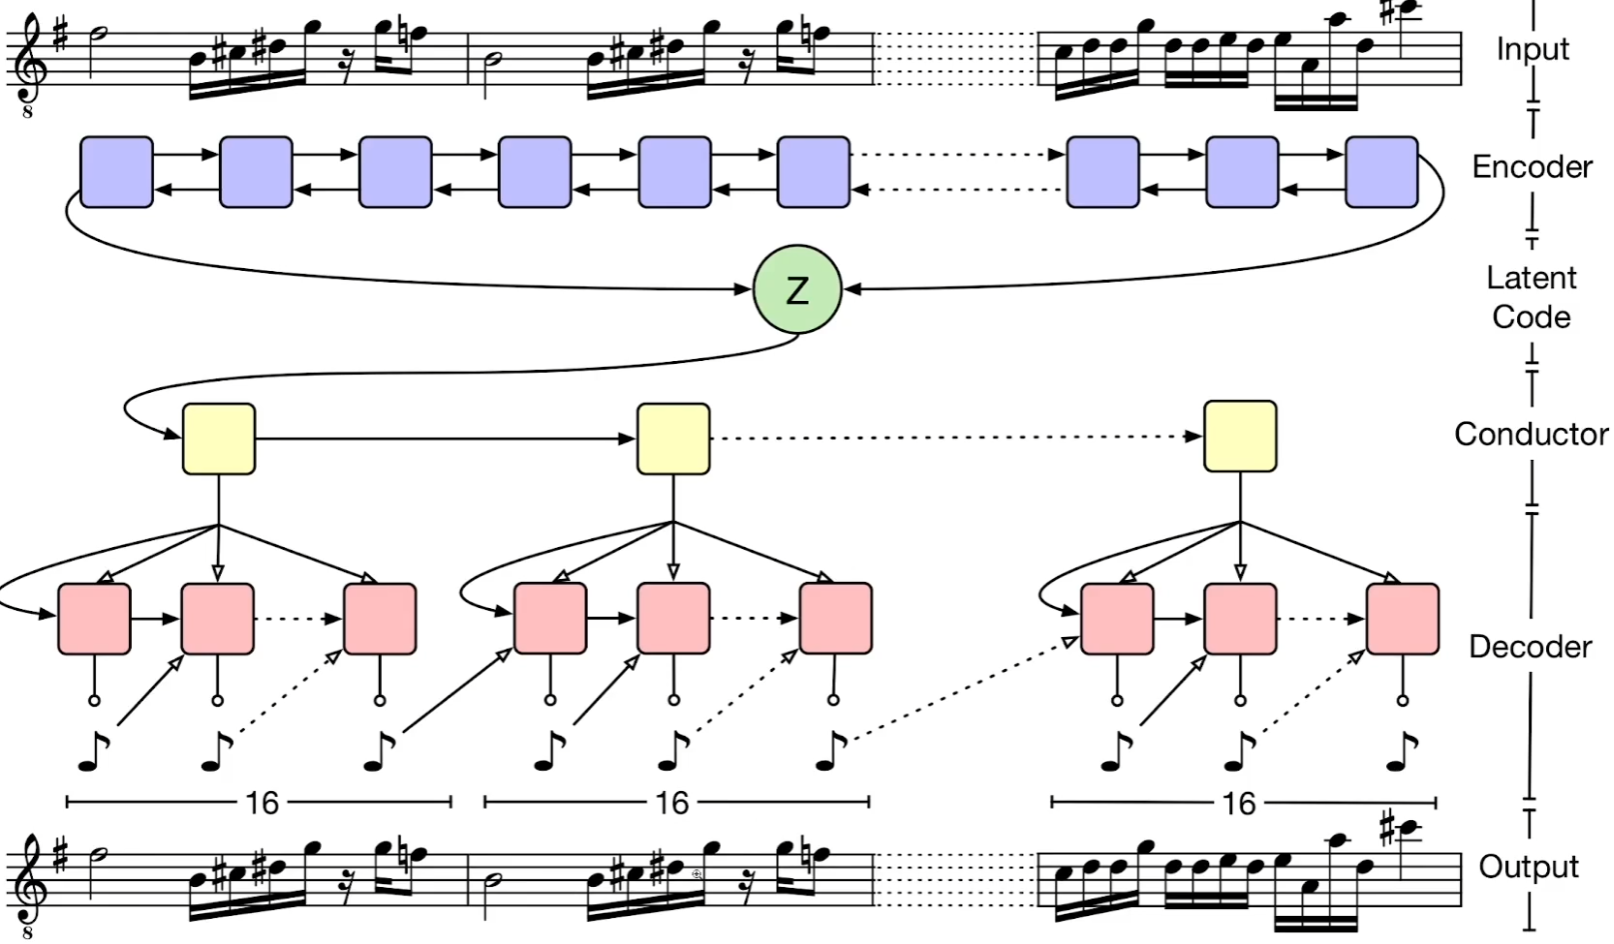


In [16]:
import jukebox
import torch as t
import librosa
import os
from IPython.display import Audio
from jukebox.make_models import make_vqvae, make_prior, MODELS, make_model
from jukebox.hparams import Hyperparams, setup_hparams
from jukebox.sample import sample_single_window, _sample, \
                           sample_partial_window, upsample
from jukebox.utils.dist_utils import setup_dist_from_mpi
from jukebox.utils.torch_utils import empty_cache
rank, local_rank, device = setup_dist_from_mpi()

Caught error during NCCL init (attempt 0 of 5): trying to initialize the default process group twice!
Caught error during NCCL init (attempt 1 of 5): trying to initialize the default process group twice!
Caught error during NCCL init (attempt 2 of 5): trying to initialize the default process group twice!
Caught error during NCCL init (attempt 3 of 5): trying to initialize the default process group twice!
Caught error during NCCL init (attempt 4 of 5): trying to initialize the default process group twice!


RuntimeError: ignored

## 하이퍼 파라미터 정의

In [17]:
model = "1b_lyrics"

hps = Hyperparams()
hps.sr = 44100 ## 오디오 크기
hps.n_samples = 8 ## 샘플 수
hps.name = 'samples'
chunk_size = 32 # chunksize
max_batch_size = 16 ## batch크기
hps.levels = 3 # 레벨?->
hps.hop_fraction = [.5,.5,.125] ## 이건뭔뎅
## 주크박스용으로만 사용
## 문서에는 미세조정하는 숫자들

vqvae, *priors = MODELS[model] ##모델 사용
vqvae = make_vqvae(setup_hparams(vqvae, dict(sample_length = 1048576)), device) ## 하이퍼 파라미터 사용
top_prior = make_prior(setup_hparams(priors[-1], dict()), vqvae, device) # 모델과 관련한 최우선 순위 찾음

Running  wget -O /root/.cache/jukebox/models/5b/vqvae.pth.tar https://openaipublic.azureedge.net/jukebox/models/5b/vqvae.pth.tar
Restored from /root/.cache/jukebox/models/5b/vqvae.pth.tar
0: Loading vqvae in eval mode
Creating cond. autoregress with prior bins [79, 2048], 
dims [384, 6144], 
shift [ 0 79]
input shape 6528
input bins 2127
Self copy is False
Loading artist IDs from /content/jukebox/jukebox/data/ids/v3_artist_ids.txt
Loading artist IDs from /content/jukebox/jukebox/data/ids/v3_genre_ids.txt
Level:2, Cond downsample:None, Raw to tokens:128, Sample length:786432
Running  wget -O /root/.cache/jukebox/models/1b_lyrics/prior_level_2.pth.tar https://openaipublic.azureedge.net/jukebox/models/1b_lyrics/prior_level_2.pth.tar
Restored from /root/.cache/jukebox/models/1b_lyrics/prior_level_2.pth.tar
0: Loading prior in eval mode


In [18]:
type(hps)

jukebox.hparams.Hyperparams

In [25]:
hps

{'sr': 44100,
 'n_samples': 8,
 'name': 'samples',
 'levels': 3,
 'hop_fraction': [0.5, 0.5, 0.125],
 'sample_length': 881920}

## sample의 길이 설정

*   20초의 sample
*   



In [19]:
sample_length_in_seconds = 20

hps.sample_length = (int(sample_length_in_seconds*hps.sr)//top_prior.raw_to_tokens)*top_prior.raw_to_tokens

## 모델 정의
## Rock , 가사 , 총 길이 (시간 초)
### 훈련된 데이터 ids에는 artist id와 genre id 가존재


In [26]:
metas = [dict(artist = "Bruno Mars",
            genre = "Pop",
            total_length = hps.sample_length,
            offset = 0,
            lyrics = """I met a traveller from an antique land,
            Who said—“Two vast and trunkless legs of stone
            Stand in the desert. . . . Near them, on the sand,
            Half sunk a shattered visage lies, whose frown,
            And wrinkled lip, and sneer of cold command,
            Tell that its sculptor well those passions read
            Which yet survive, stamped on these lifeless things,
            The hand that mocked them, and the heart that fed;
            And on the pedestal, these words appear:
            My name is Ozymandias, King of Kings;
            Look on my Works, ye Mighty, and despair!
            Nothing beside remains. Round the decay
            Of that colossal Wreck, boundless and bare
            The lone and level sands stretch far away
            """,
            ),
          ] * hps.n_samples
labels = [None, None, top_prior.labeller.get_batch_labels(metas, 'cuda')]

## Meta 는 sample의 수만큼 dictionarty일 뿐
## 각 입력으로 들어가는 노래인듯?

In [27]:
metas

[{'artist': 'Bruno Mars',
  'genre': 'Pop',
  'total_length': 881920,
  'offset': 0,
  'lyrics': 'I met a traveller from an antique land,\n            Who said—“Two vast and trunkless legs of stone\n            Stand in the desert. . . . Near them, on the sand,\n            Half sunk a shattered visage lies, whose frown,\n            And wrinkled lip, and sneer of cold command,\n            Tell that its sculptor well those passions read\n            Which yet survive, stamped on these lifeless things,\n            The hand that mocked them, and the heart that fed;\n            And on the pedestal, these words appear:\n            My name is Ozymandias, King of Kings;\n            Look on my Works, ye Mighty, and despair!\n            Nothing beside remains. Round the decay\n            Of that colossal Wreck, boundless and bare\n            The lone and level sands stretch far away\n            '},
 {'artist': 'Bruno Mars',
  'genre': 'Pop',
  'total_length': 881920,
  'offset': 0,
  

In [28]:
sampling_temperature = .98

lower_batch_size = 16
max_batch_size = 16
lower_level_chunk_size = 32
chunk_size = 32
sampling_kwargs = [dict(temp=.99, fp16=True, max_batch_size=lower_batch_size,
                        chunk_size=lower_level_chunk_size),
                    dict(temp=0.99, fp16=True, max_batch_size=lower_batch_size,
                         chunk_size=lower_level_chunk_size),
                    dict(temp=sampling_temperature, fp16=True,
                         max_batch_size=max_batch_size, chunk_size=chunk_size)]

In [29]:
zs = [t.zeros(hps.n_samples,0,dtype=t.long, device='cuda') for _ in range(len(priors))]
zs = _sample(zs, labels, sampling_kwargs, [None, None, top_prior], [2], hps)

Sampling level 2
Sampling 6144 tokens for [0,6144]. Conditioning on 0 tokens
Ancestral sampling 8 samples with temp=0.98, top_k=0, top_p=0.0
12/12 [00:01<00:00,  7.87it/s]
6144/6144 [11:30<00:00,  8.90it/s]
Sampling 6144 tokens for [746,6890]. Conditioning on 5398 tokens
Primed sampling 8 samples with temp=0.98, top_k=0, top_p=0.0
181/181 [00:29<00:00,  6.04it/s]
746/746 [01:20<00:00,  9.24it/s]


In [30]:
Audio(f'{hps.name}/level_2/item_0.wav')